# PyLops - Class-based solvers in v2

This notebook provides a tour of the new class-based solvers in PyLops and how they can be invoked with different level of abstraction (more abstraction <-> less flexibility)

In [1]:
%load_ext autoreload
%autoreload 2

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops
from scipy.sparse.linalg import cg as sp_cg
from pylops.basicoperators import Identity
from pylops.optimization.callback import ResidualNormCallback
from pylops.optimization.cls_basic import CG, CGLS, LSQR
from pylops.optimization.cls_leastsquares import NormalEquationsInversion, RegularizedInversion, PreconditionedInversion
from pylops.optimization.cls_sparsity import IRLS, OMP, ISTA, FISTA, SPGL1, SplitBregman
from pylops.optimization.basic import cg, cgls, lsqr
from pylops.optimization.leastsquares import normal_equations_inversion, regularized_inversion, preconditioned_inversion
from pylops.optimization.sparsity import irls, omp, ista, fista, spgl1, splitbregman

from solver_old import cg as cg_old
from solver_old import cgls as cgls_old
from solver_old import lsqr as lsqr_old
from leastsquares_old import NormalEquationsInversion as normal_equations_inversion_old
from leastsquares_old import RegularizedInversion as regularized_inversion_old
from leastsquares_old import PreconditionedInversion as preconditioned_inversion_old
from sparsity_old import IRLS as irls_old
from sparsity_old import OMP as omp_old
from sparsity_old import ISTA as ista_old
from sparsity_old import FISTA as fista_old
from sparsity_old import SPGL1 as spgl1_old
from sparsity_old import SplitBregman as splitbregman_old

In [2]:
def callback(xx, xhist):
    xhist.append(xx.copy())

def callback1(xx, cols, xhist):
    xhist.append(xx.copy())

## CG

In [3]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

### Step-by-step solver

The most verbose of the options:

- Create the solver object
- Setup the solver with data, solver hyperparameters (and, optionally, the initial guess). This will return the initial guess to be passed to step
- Step the solver Niter times passing x (at iter i-1) and obtaining x (at iter i)
- Optionally interleave step with callback
- Finalize solver

In [4]:
cgsolve = CG(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
for i in range(ny):
    x = cgsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
cgsolve.finalize(True)
xest = x.copy()

CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00
-------------------------------------------------------

    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4360e-05
    41         1.0000e+00         8.2045e-08
    51         1.0000e+00         7.1835e-12
    61         1.0000e+00         1.8505e-22
    71         1.0000e+00         6.6013e-27
    81         1.0000e+00         1.6632e-30
    91         1.0000e+00         8.9952e-34

Iterations = 100        Total time (s) = 0.00
-------------------------------------------------------



In [5]:
xhist[0]

array([ 0.00623054, -0.08018339,  0.39960984,  0.62411442,  1.08859636,
        0.38381985,  0.6964201 ,  1.04585291,  0.75853243,  0.68292631,
        0.3161173 ,  0.27607787,  0.72731135,  0.52669676,  0.11739324,
        0.14758833,  0.85023401,  0.80690362,  1.26129193,  0.48751973,
        0.12586797,  0.88287304,  0.81393472,  0.81674471,  0.17009951,
       -0.10212194,  1.09518642,  1.10737678,  0.00483318,  0.71825152,
        0.41483263,  0.92885864,  0.72719834,  0.30835651,  0.00494972,
        0.39449335, -0.01485279,  0.1739736 ,  0.97196505,  0.24290925,
        0.98533785,  0.3677009 ,  0.6948482 ,  0.82346676,  1.19474566,
        0.91422985,  0.67712503,  0.64024807,  0.68718705,  0.89545759])

In [6]:
cgsolve = CG(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
x = cgsolve.run(x, ny, show=True)
cgsolve.finalize(True)
xest = x.copy()

CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00
-------------------------------------------------------

    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
     5         1.0986e+00         2.8867e+01
     6         1.0980e+00         1.7638e+01
     7         1.0594e+00         1.1285e+01
     8         1.0419e+00         7.3059e+00
     9         1.0396e+00         5.4244e+00
    10         1.0275e+00         3.8095e+00
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4360e-05
    41         1.0000e+00         8.2045e-08
    51         1.0000e+00         7.1835e-12
    61         1.0000e+00         1.8505e-22
    71         1.0000e+00         6.6013e-27
    81         1.

### Class based solver

The second most verbose of the options:

- Create the solver object
- Run the solve method with data, initial model and solver hyperparameters

In [7]:
# class based solver
cgsolve = CG(Aop)
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=True, itershow=[4,3,10])[0]

CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-------------------------------------------------------

    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4360e-05
    41         1.0000e+00         8.2045e-08
    51         1.0000e+00         7.1835e-12
    61         1.0000e+00         1.8505e-22
    71         1.0000e+00         6.6013e-27
    81         1.0000e+00         1.6632e-30
    91         1.0000e+00         8.9952e-34
    99         1.0000e+00         8.1967e-37
   100         1.0000e+00         3.0192e-37

Iterations = 100        Total time (s) = 0.00
------------------------------------------------

### Function based solver

The least verbose of the options (like in PyLops v1). Simply call the function equivalent of the solver that is a thin wrapper around what just did in the previous code block.

In [8]:
xhist = []
xest2 = cg(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True, 
           callback=lambda x: callback(x, xhist))[0]
xest3 = cg_old(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True)[0]

CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-------------------------------------------------------

    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
     5         1.0986e+00         2.8867e+01
     6         1.0980e+00         1.7638e+01
     7         1.0594e+00         1.1285e+01
     8         1.0419e+00         7.3059e+00
     9         1.0396e+00         5.4244e+00
    10         1.0275e+00         3.8095e+00
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4360e-05
    41         1.0000e+00         8.2045e-08
    51         1.0000e+00         7.1835e-12
    61         1.0000e+00         1.8505e-22
    71         1.0000e+00         6.6013e-27
    8

In [9]:
xhist[0]

array([ 0.00623054, -0.08018339,  0.39960984,  0.62411442,  1.08859636,
        0.38381985,  0.6964201 ,  1.04585291,  0.75853243,  0.68292631,
        0.3161173 ,  0.27607787,  0.72731135,  0.52669676,  0.11739324,
        0.14758833,  0.85023401,  0.80690362,  1.26129193,  0.48751973,
        0.12586797,  0.88287304,  0.81393472,  0.81674471,  0.17009951,
       -0.10212194,  1.09518642,  1.10737678,  0.00483318,  0.71825152,
        0.41483263,  0.92885864,  0.72719834,  0.30835651,  0.00494972,
        0.39449335, -0.01485279,  0.1739736 ,  0.97196505,  0.24290925,
        0.98533785,  0.3677009 ,  0.6948482 ,  0.82346676,  1.19474566,
        0.91422985,  0.67712503,  0.64024807,  0.68718705,  0.89545759])

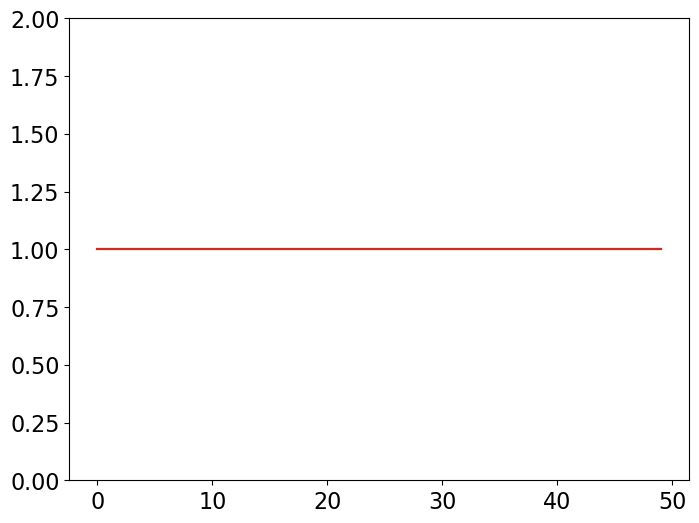

In [10]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2);

In [11]:
xest-xest1, xest1-xest2, xest1-xest3

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### Check with scipy

In [12]:
xsp = sp_cg(Aop, y, maxiter=ny, rtol=0)[0]

xest-xsp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## CG with complex numbers

In [13]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

In [14]:
# function based solver
xest2 = cg(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]#, callback=callback)[0]
xest3 = cg_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]

CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-------------------------------------------------------

    Itn              x[0]                  r2norm
     1        5.17e-01+5.17e-01j         4.5201e+02
     2        7.99e-01+7.99e-01j         1.9958e+02
     3        9.80e-01+9.80e-01j         1.2913e+02
     4        1.15e+00+1.15e+00j         7.1300e+01
     5        1.20e+00+1.20e+00j         4.5552e+01
     6        1.16e+00+1.16e+00j         3.2619e+01
     7        1.08e+00+1.08e+00j         1.4674e+01
     8        1.06e+00+1.06e+00j         1.1070e+01
     9        1.02e+00+1.02e+00j         9.0341e+00
    10        1.00e+00+1.00e+00j         4.8805e+00
    11        9.98e-01+9.98e-01j         3.1756e+00
    21        1.00e+00+1.00e+00j         3.6058e-02
    31        1.00e+00+1.00e+00j         1.8360e-04
    41        1.00e+00+1.00e+00j         7.3261e-07
    51        1.00e+00+1.00e+00j   

## CG with multiple RHS (just to remember it does not work right now!)

In [15]:
# np.random.seed(1)
ny, nx, nrhs = 100, 50, 4
x = np.outer(np.ones(nx), np.arange(nrhs)+1)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

In [16]:
# We can make an operator acting on an extended vector and use add_ndarray_support_to_solver... 
# but this is still NOT solving multiple RHS, for that we need to FIX the solver...
from pylops.utils.decorators import add_ndarray_support_to_solver

Aop = pylops.MatrixMult(A, otherdims=(4,))
py_cg_ndarray = add_ndarray_support_to_solver(cg)
py_cg_ndarray(Aop, y, x0=np.zeros((nx, nrhs)), niter=4);

# CGLS

In [17]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

## Step-by-step solver

In [18]:
cgsolve = CGLS(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
cgsolve.niter = ny
for i in range(ny):
    x = cgsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
cgsolve.finalize(True)
xest = x.copy()

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    31        1.0000e+00         1.2494e-05     1.2494e-05
    41        1.0000e+00         1.2976e-08     1.2976e-08
    51        1.0000e+00         9.6854e-13     9.6854e-13
    61        1.0000e+00         1.0260e-14     1.0260e-14
    71        1.0000e+00         1.0260e-14     1.0260e-14
    81        1.0000e+00         1.0260e-14     1.0260e-14
    91        1.0000e+00         1.0260e-14     1.0260e-14

Iterations = 100        Total time (s) = 0.00
-----------------------------------------------------------------



## Class based solver

In [19]:
# class based solver
cgsolve = CGLS(Aop)
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=True, itershow=[4,3,10])[0]

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    31        1.0000e+00         1.2494e-05     1.2494e-05
    41        1.0000e+00         1.2976e-08     1.2976e-08
    51        1.0000e+00         9.6854e-13     9.6854e-13
    61        1.0000e+00         1.0260e-14     1.0260e-14
    71        1.0000e+00         1.0260e-14     1.0260e-14
    81        1.0000e+00         1.0260e-14     1.0260e-14
    9

## Function based solver

In [20]:
xhist = []
xest2 = cgls(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True, 
           callback=lambda x: callback(x, xhist))[0]
xest3 = cgls_old(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True)[0]

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
     5        1.0986e+00         3.7566e+00     3.7566e+00
     6        1.0980e+00         2.3773e+00     2.3773e+00
     7        1.0594e+00         1.5883e+00     1.5883e+00
     8        1.0419e+00         1.1075e+00     1.1075e+00
     9        1.0396e+00         7.8965e-01     7.8965e-01
    10        1.0275e+00         5.7929e-01     5.7929e-01
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    3

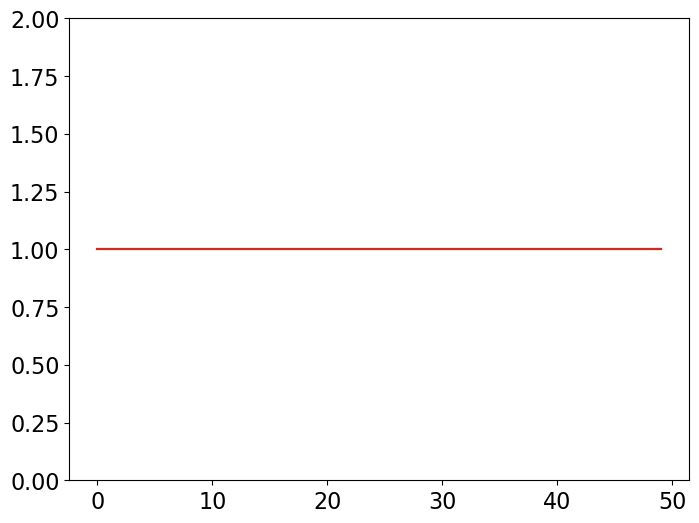

In [21]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2);

## CGLS with complex numbers

In [22]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [23]:
# function based solver
xest2 = cgls(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]#, callback=callback)[0]
xest3 = cgls_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------------

    Itn             x[0]             r1norm         r2norm
     1       5.17e-01+5.17e-01j    4.6880e+01     4.6880e+01
     2       7.99e-01+7.99e-01j    2.4899e+01     2.4899e+01
     3       9.80e-01+9.80e-01j    1.5539e+01     1.5539e+01
     4       1.15e+00+1.15e+00j    9.2586e+00     9.2586e+00
     5       1.20e+00+1.20e+00j    5.9991e+00     5.9991e+00
     6       1.16e+00+1.16e+00j    3.7820e+00     3.7820e+00
     7       1.08e+00+1.08e+00j    2.4593e+00     2.4593e+00
     8       1.06e+00+1.06e+00j    1.7537e+00     1.7537e+00
     9       1.02e+00+1.02e+00j    1.1751e+00     1.1751e+00
    10       1.00e+00+1.00e+00j    6.7791e-01     6.7791e-01
    11       9.98e-01+9.98e-01j    4.2278e-01     4.2278e-01
    21       1.00e+00+1.00e+00j    5.340

In [24]:
xest2-xest3

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

# LSQR

In [25]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

## Step-by-step solver

In [26]:
lsqrsolve = LSQR(Aop)

xhist = []
lsqrsolve.callback = lambda x: callback(x, xhist)

x = lsqrsolve.setup(y=y, x0=np.zeros(nx), atol=0, show=True)
for i in range(ny):
    x = lsqrsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
lsqrsolve.finalize(True)
xest = x.copy()

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
    11  1.0200e+00  3.888e-01  3.888e-01   5.4e-03  3.0e-03  4.0e+01  1.6e+01
    21  9.9997e-01  3.232e-03  3.232e-03   4.5e-05  2.5e-05  5.2e+01  3.2e+01
    31  1.0000e+00  1.249e-05  1.249e-05   1.7e-07  9.6e-08  6.1e+01  4.7e+01
    41  1.0000e+00  1.145e-08  1.145e-08   1.6e-10  1.3e-10  6.9e+01  6.1e+01
    51  1.0000e+00  9.562e-13  9.562e-13   1.3e-14  8.2e-15  7.6e+01  7.4e+01
    61  1.0000e+00

## Class based solver

In [27]:
# class based solver
lsqrsolve = LSQR(Aop)
xest1 = lsqrsolve.solve(y=y, x0=np.zeros(nx), atol=0, btol=0, 
                        niter=ny, show=True, itershow=[4,3,10])[0]

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00                 niter =      100
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
     2  5.4117e-01  1.569e+01  1.569e+01   2.2e-01  1.7e-01  1.9e+01  2.2e+00
     3  8.2224e-01  9.248e+00  9.248e+00   1.3e-01  8.2e-02  2.3e+01  3.4e+00
     4  9.1420e-01  6.325e+00  6.325e+00   8.7e-02  5.3e-02  2.6e+01  4.7e+00
    11  1.0200e+00  3.888e-01  3.888e-01   5.4e-03  3.0e-03  4.0e+01  1.6e+01
    21  9.9997e-01  3.232e-03  3.232e-03   4.5e-05  2.5e-05  5.2e+01  3.2e+01
    31  1.0000e+00

## Function based solver

In [28]:
xhist = []
xest2 = lsqr(Aop, y, np.zeros(nx), niter=ny, atol=0, show=True, 
             callback=lambda x: callback(x, xhist))[0]
xest3 = lsqr_old(Aop, y, np.zeros(nx), niter=ny, atol=0, show=True)[0]

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =      100
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
     2  5.4117e-01  1.569e+01  1.569e+01   2.2e-01  1.7e-01  1.9e+01  2.2e+00
     3  8.2224e-01  9.248e+00  9.248e+00   1.3e-01  8.2e-02  2.3e+01  3.4e+00
     4  9.1420e-01  6.325e+00  6.325e+00   8.7e-02  5.3e-02  2.6e+01  4.7e+00
     5  1.0986e+00  3.757e+00  3.757e+00   5.2e-02  3.3e-02  2.8e+01  6.4e+00
     6  1.0980e+00  2.377e+00  2.377e+00   3.3e-02  2.0e-02  3.1e+01  7.9e+00
     7  1.0594e+00

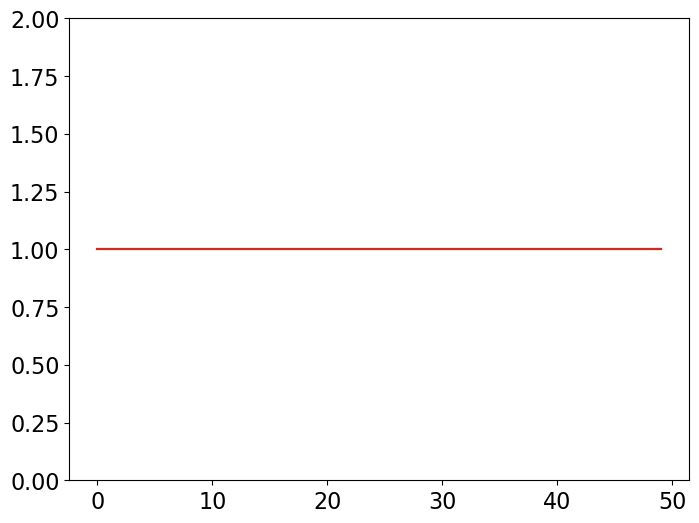

In [29]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2);

## LSQR with complex numbers

In [30]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [31]:
# function based solver
xest2 = lsqr(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, atol=0, show=True)[0]
xest3 = lsqr_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, atol=0, show=True)[0]

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =      100
------------------------------------------------------------------------------------------
   Itn        x[0]              r1norm    r2norm   Compatible   LS     Norm A   Cond A
     0 0.00e+00+0.00e+00j     9.498e+01  9.498e+01   1.0e+00  1.3e-01
     1 5.17e-01+5.17e-01j     4.688e+01  4.688e+01   4.9e-01  3.9e-01  1.4e+01  1.0e+00
     2 7.99e-01+7.99e-01j     2.490e+01  2.490e+01   2.6e-01  1.7e-01  1.9e+01  2.2e+00
     3 9.80e-01+9.80e-01j     1.554e+01  1.554e+01   1.6e-01  1.1e-01  2.2e+01  3.5e+00
     4 1.15e+00+1.15e+00j     9.259e+00  9.259e+00   9.7e-02  6.2e-02  2.5e+01  5.0e+00
     5 1.20e+00+1.20e+00j     5.999e+00  5.999e+00   6.3e-02  3.9e-02  2.8e+01  6.5e+00
     6 1.16e+00+1.16e+00j 

In [32]:
xest2-xest3

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

# NormalEquationInversion

In [33]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Dop = pylops.FirstDerivative(50)

In [34]:
nesolve = NormalEquationsInversion(Aop)

xhist = []
nesolve.callback = lambda x: callback(x, xhist)

# scipy
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
                  epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='scipy', **dict(maxiter=5))[0]
nesolve.finalize(show=True)
xest = x.copy()

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]     epsI=0
-------------------------------------------------------

Total time (s) = 0.00
-------------------------------------------------------



In [35]:
# pylops
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
                  epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='pylops', **dict(niter=5, show=True))[0]
nesolve.finalize(True)
xestpylops = x.copy()

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]     epsI=0
-------------------------------------------------------
CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 1.000000e-04	niter = 5
-------------------------------------------------------

    Itn           x[0]              r2norm
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03

Iterations = 5        Total time (s) = 0.00
-------------------------------------------------------



In [36]:
xest1 = normal_equations_inversion_old(Aop, Regs=[Dop, ], data=y, dataregs=[np.zeros(nx)], 
                                       epsRs=[1e-1, ], x0=np.zeros(nx), **dict(maxiter=5))

In [37]:
xest-xest1, xest-xestpylops

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

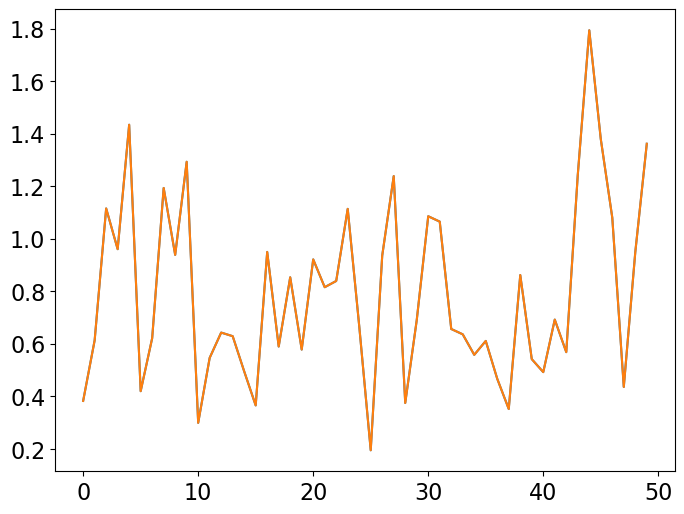

In [38]:
plt.plot(xest)
plt.plot(xestpylops)

In [39]:
nesolve = NormalEquationsInversion(Aop)

xest1 = nesolve.solve(y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)], 
                      epsRs=[1e-1, 1e-2], x0=np.zeros(nx), 
                      engine='pylops', **dict(niter=20, show=True))[0]

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]     epsI=0
-------------------------------------------------------
CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 1.000000e-04	niter = 20
-------------------------------------------------------

    Itn           x[0]              r2norm
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03
     6         5.1653e-01         6.5985e+03
     7         6.7217e-01         5.4724e+03
     8         7.9452e-01         3.7607e+03
     9         8.7658e-01         3.1885e+03
    10         9.5870e-01         2.8390e+03
    11         1.0049

In [40]:
xest2 = normal_equations_inversion(Aop, y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)],
                                   epsRs=[1e-1, 1e-2], x0=np.zeros(nx), engine='pylops', 
                                   **dict(niter=20, show=True))[0]

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]     epsI=0.0
-------------------------------------------------------
CG
-------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 1.000000e-04	niter = 20
-------------------------------------------------------

    Itn           x[0]              r2norm
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03
     6         5.1653e-01         6.5985e+03
     7         6.7217e-01         5.4724e+03
     8         7.9452e-01         3.7607e+03
     9         8.7658e-01         3.1885e+03
    10         9.5870e-01         2.8390e+03
    11         1.00

In [41]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# RegularizedInversion

In [42]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Dop = pylops.FirstDerivative(50)

In [43]:
nesolve = RegularizedInversion(Aop)

xhist = []
nesolve.callback = lambda x: callback(x, xhist)

# scipy
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
              epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='scipy', show=True, **dict(iter_lim=20))[0]
nesolve.finalize(show=True)
xest = x.copy()

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 100 rows and 50 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.830e+02  8.830e+02    1.0e+00  2.2e-01
     1 -2.57946e-01   4.737e+02  4.737e+02    5.4e-01  6.3e-01   2.3e+02  1.0e+00
     2 -1.34239e-01   3.132e+02  3.132e+02    3.5e-01  4.0e-01   3.2e+02  2.2e+00
     3  2.03611e-01   2.172e+02  2.172e+02    2.5e-01  3.0e-01   3.8e+02  3.7e+00
     4  2.86691e-01   1.370e+02  1.370e+02    1.6e-01  2.6e-01   4.2e+02  5.4e+00
     5  3.82437e-01   1.026e

In [44]:
# pylops
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
              epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='pylops', show=True, **dict(niter=20))[0]
nesolve.finalize(True)
xestpylops = x.copy()

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e+01
     8        7.9452e-01         6.0386e+01   

In [45]:
xest1 = regularized_inversion_old(Aop, Regs=[Dop, ], data=y, dataregs=[np.zeros(nx)], 
                                  epsRs=[1e-1, ], x0=np.zeros(nx), **dict(iter_lim=20))

In [46]:
xest-xest1, xestpylops-xest1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 1.49180828e-08,  2.50765531e-09, -6.46652489e-08, -1.06514697e-07,
         4.42576842e-09,  5.87791417e-08,  8.27596625e-09,  1.11991994e-07,
        -1.04288159e-07, -3.66113471e-08,  1.68816791e-08,  3.62010961e-08,
        -1.34003192e-08,  3.83251701e-08, -2.28128132e-08,  2.49854195e-08,
         9.34965662e-08,  7.16033048e-08,  1.96797678e-07,  4.79914932e-08,
         2.85160069e-08, -6.57530230e-09,  1.17992573e-08,  4.07768408e-09,
        -8.64953382e-08, -5.76993839e-08,  4.36274763e-08,  8.68940793e-08,
         9.95511273e-09,  3.50116829e-08, -7.67851577e-08,  1.25712340e-07,
         4.41612173e-08, -3.10368071e-08, -6.26069023e-08, -1.01797475e-08,
        -8.67902092e-08,  1.87567588e-08, -2.58008372e-08, -7.47289888e-08,
         9.909

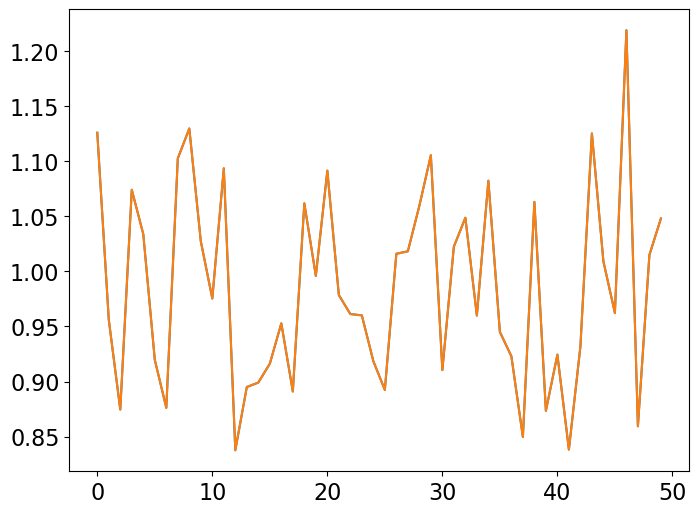

In [47]:
plt.plot(xest)
plt.plot(xestpylops)

In [48]:
nesolve = RegularizedInversion(Aop)

xest1 = nesolve.solve(y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)], 
                  epsRs=[1e-1, 1e-2], x0=np.zeros(nx), 
                  engine='pylops', show=True, **dict(niter=20))[0]

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 150 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e

In [49]:
xest2 = regularized_inversion(Aop, y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)],
                              epsRs=[1e-1, 1e-2], x0=np.zeros(nx), engine='pylops', 
                              **dict(niter=20, show=True))[0]

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 150 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e

In [50]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Preconditioned Inversion

In [51]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Sop = pylops.Smoothing1D(5, 50)

In [52]:
psolve = PreconditionedInversion(Aop)

xhist = []
psolve.callback = lambda x: callback(x, xhist)

# scipy
psolve.setup(y=y, P=Sop, show=True)
x = psolve.run(None, engine='scipy', show=True, **dict(iter_lim=20))[0]
psolve.finalize(show=True)
xest = x.copy()

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Smoothing1D with dtype=float64>
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 50 rows and 50 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.830e+02  8.830e+02    1.0e+00  1.6e-01
     1 -3.08154e-01   2.847e+02  2.847e+02    3.2e-01  7.0e-01   1.5e+02  1.0e+00
     2 -6.72941e-03   1.538e+02  1.538e+02    1.7e-01  3.8e-01   2.0e+02  2.1e+00
     3  4.57448e-01   8.411e+01  8.411e+01    9.5e-02  3.2e-01   2.2e+02  3.6e+00
     4  6.47640e-01   5.606e+01  5.606e+01    6.3e-02  2.2e-01   2.5e+02  4.9e+00
     5  7.35499e-01   4.974e+01  4.974e+01  

In [53]:
# pylops
psolve.setup(y=y, P=Sop, show=True)
x = psolve.run(None, engine='pylops', show=True, **dict(niter=20))[0]
psolve.finalize(True)
xestpylops = x.copy()

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Smoothing1D with dtype=float64>
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
   

In [54]:
xest-xestpylops

array([-4.45958565e-03,  3.92073476e-04,  2.77978831e-03, -5.58055687e-03,
       -6.46259702e-03,  3.25852023e-04, -2.18345695e-03, -1.26402510e-03,
        5.87314174e-03,  1.10853554e-03, -4.41655465e-03, -8.08885789e-04,
        9.16698982e-04,  2.56764381e-03,  2.47681276e-03,  3.15254137e-03,
       -1.23213441e-03, -8.78235109e-03, -5.07809090e-04,  4.88392229e-03,
        5.74158996e-03, -9.80156025e-05,  3.37065611e-03, -5.76784558e-03,
       -4.45893995e-03,  3.37884797e-03,  2.55193343e-03,  6.45999565e-03,
        4.83535942e-03,  8.79562488e-03,  4.25810220e-04,  3.86380638e-03,
        1.44724523e-03,  4.71690572e-03, -2.10237313e-04,  6.32942563e-05,
       -7.23222420e-04, -2.21931013e-03,  5.64310827e-04,  2.63485627e-03,
        6.12695467e-03,  8.52660276e-03,  3.33922067e-03,  2.76654723e-03,
       -8.05884484e-04, -1.22669571e-02, -1.15817247e-03,  9.95508508e-04,
       -1.95222968e-03, -1.58868580e-03])

In [55]:
xest1 = preconditioned_inversion_old(Aop, Sop, data=y, x0=np.zeros(nx), **dict(iter_lim=20))

In [56]:
xest-xest1, xestpylops-xest1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 4.45958565e-03, -3.92073476e-04, -2.77978831e-03,  5.58055687e-03,
         6.46259702e-03, -3.25852023e-04,  2.18345695e-03,  1.26402510e-03,
        -5.87314174e-03, -1.10853554e-03,  4.41655465e-03,  8.08885789e-04,
        -9.16698982e-04, -2.56764381e-03, -2.47681276e-03, -3.15254137e-03,
         1.23213441e-03,  8.78235109e-03,  5.07809090e-04, -4.88392229e-03,
        -5.74158996e-03,  9.80156025e-05, -3.37065611e-03,  5.76784558e-03,
         4.45893995e-03, -3.37884797e-03, -2.55193343e-03, -6.45999565e-03,
        -4.83535942e-03, -8.79562488e-03, -4.25810220e-04, -3.86380638e-03,
        -1.44724523e-03, -4.71690572e-03,  2.10237313e-04, -6.32942563e-05,
         7.23222420e-04,  2.21931013e-03, -5.64310827e-04, -2.63485627e-03,
        -6.126

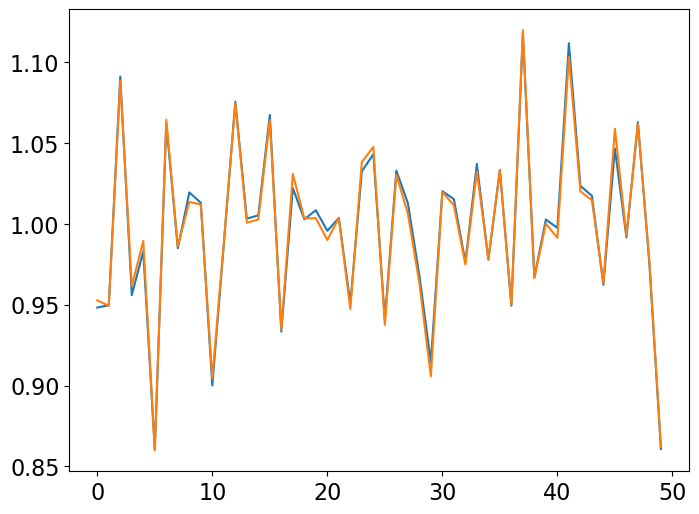

In [57]:
plt.plot(xest)
plt.plot(xestpylops)

In [58]:
nesolve = PreconditionedInversion(Aop)

xest1 = nesolve.solve(y=y, P=Sop, x0=np.zeros(nx), 
                      engine='pylops', **dict(niter=20, show=True))[0]

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Smoothing1D with dtype=float64>
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
   

In [59]:
xest2 = preconditioned_inversion(Aop, y=y, P=Sop,  x0=np.zeros(nx), engine='pylops', 
                              **dict(niter=20, show=True))[0]

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Smoothing1D with dtype=float64>
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 50 rows and 50 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
   

In [60]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# ISTA

In [61]:
np.random.seed(1)
ny, nx = 100, 50

x = np.zeros(nx)
x[nx // 2] = 1
x[3] = 1
x[nx - 4] = -1

A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = Aop * x

eps = 0.5
perc = 30
maxit = 2000

In [62]:
istasolve = ISTA(Aop)

xhist = []
istasolve.callback = lambda x: callback(x, xhist)

x = istasolve.setup(y=y, niter=maxit, eps=eps, tol=0, show=True)
x = istasolve.run(x, show=True)
istasolve.finalize(show=True)
xinv = x.copy()

ISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7204e-02         1.853e+02   1.873e+02   9.027e-01
     2      -6.8699e-02         3.709e+01   3.942e+01   3.121e-01
     3      -6.6018e-02         1.613e+01   1.852e+01   1.703e-01
     4      -5.9575e-02         9.384e+00   1.176e+01   1.127e-01
     5      -5.2467e-02         6.301e+00   8.630e+00   8.334e-02
     6      -4.5670e-02         4.580e+00   6.850e+00   6.608e-02
     7      -3.9289e-02         3.487e+00   5.696e+00   5.484e-02
     8      -3.3378e-02         2.734e+00   4.887e+00   4.673e-02
     9      -2.7858e-02         2.186e+00   4.286e+00   4.076e-02
    10      -2.2860

In [63]:
xinv1, _, _ = ista(Aop, y, niter=maxit, eps=eps, tol=0, show=True)

ISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7204e-02         1.853e+02   1.873e+02   9.027e-01
     2      -6.8699e-02         3.709e+01   3.942e+01   3.121e-01
     3      -6.6018e-02         1.613e+01   1.852e+01   1.703e-01
     4      -5.9575e-02         9.384e+00   1.176e+01   1.127e-01
     5      -5.2467e-02         6.301e+00   8.630e+00   8.334e-02
     6      -4.5670e-02         4.580e+00   6.850e+00   6.608e-02
     7      -3.9289e-02         3.487e+00   5.696e+00   5.484e-02
     8      -3.3378e-02         2.734e+00   4.887e+00   4.673e-02
     9      -2.7858e-02         2.186e+00   4.286e+00   4.076e-02
    10      -2.2860

In [64]:
xinv2, _ = ista_old(Aop, y, niter=maxit, eps=eps, tol=0, show=True)

ISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -5.72037e-02   1.853e+02   1.873e+02   9.027e-01
     2  -6.86987e-02   3.709e+01   3.942e+01   3.121e-01
     3  -6.60182e-02   1.613e+01   1.852e+01   1.703e-01
     4  -5.95750e-02   9.384e+00   1.176e+01   1.127e-01
     5  -5.24673e-02   6.301e+00   8.630e+00   8.334e-02
     6  -4.56698e-02   4.580e+00   6.850e+00   6.608e-02
     7  -3.92893e-02   3.487e+00   5.696e+00   5.484e-02
     8  -3.33785e-02   2.734e+00   4.887e+00   4.673e-02
     9  -2.78585e-02   2.186e+00   4.286e+00   4.076e-02
    10  -2.28595e-02   1.771e+00   3.824e+00   3.594e-02
    11  -1.84860e-02   1.449e+00   3.460e+00   3.206e-02
    21   0.00000e+00   

In [65]:
xinv-xinv1, xinv1-xinv2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Do multiple setup and check it doesnt recompute eigenvalues (to check, need to add a print after `elif not hasattr(self, "alpha"):`

In [66]:
istasolve = ISTA(Aop)

xhist = []
istasolve.callback = lambda x: callback(x, xhist)

for i in range(5):
    x = istasolve.setup(y=y, niter=maxit, eps=eps, tol=0, show=False)
x = istasolve.run(x, show=True)
istasolve.finalize(show=True)
xinv = x.copy()

     1      -5.7204e-02         1.853e+02   1.873e+02   9.027e-01
     2      -6.8699e-02         3.709e+01   3.942e+01   3.121e-01
     3      -6.6018e-02         1.613e+01   1.852e+01   1.703e-01
     4      -5.9575e-02         9.384e+00   1.176e+01   1.127e-01
     5      -5.2467e-02         6.301e+00   8.630e+00   8.334e-02
     6      -4.5670e-02         4.580e+00   6.850e+00   6.608e-02
     7      -3.9289e-02         3.487e+00   5.696e+00   5.484e-02
     8      -3.3378e-02         2.734e+00   4.887e+00   4.673e-02
     9      -2.7858e-02         2.186e+00   4.286e+00   4.076e-02
    10      -2.2860e-02         1.771e+00   3.824e+00   3.594e-02
    11      -1.8486e-02         1.449e+00   3.460e+00   3.206e-02
    21       0.0000e+00         2.454e-01   1.980e+00   1.336e-02
    31      -0.0000e+00         4.279e-02   1.619e+00   7.001e-03
    41      -0.0000e+00         5.928e-03   1.506e+00   3.315e-03
    51      -0.0000e+00         9.199e-04   1.498e+00   1.556e-04
    61    

# FISTA

In [67]:
fistasolve = FISTA(Aop)

xhist = []
fistasolve.callback = lambda x: callback(x, xhist)

x = fistasolve.setup(y=y, niter=maxit, eps=eps, tol=0, show=True)
x = fistasolve.run(x, show=True)
istasolve.finalize(show=True)
xinv = x.copy()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7204e-02         3.709e+01   3.906e+01   9.027e-01
     2      -6.8699e-02         1.613e+01   1.846e+01   3.121e-01
     3      -6.5263e-02         8.011e+00   1.043e+01   2.183e-01
     4      -5.4173e-02         4.477e+00   6.846e+00   1.614e-01
     5      -4.0641e-02         2.678e+00   4.928e+00   1.273e-01
     6      -2.6728e-02         1.622e+00   3.749e+00   1.063e-01
     7      -1.3674e-02         9.559e-01   2.970e+00   9.183e-02
     8      -2.0595e-03         5.320e-01   2.457e+00   8.005e-02
     9       5.5145e-03         2.715e-01   2.120e+00   6.973e-02
    10       9.829

In [68]:
xinv1, _, _ = fista(Aop, y, niter=maxit, eps=eps, tol=0, show=True)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7204e-02         3.709e+01   3.906e+01   9.027e-01
     2      -6.8699e-02         1.613e+01   1.846e+01   3.121e-01
     3      -6.5263e-02         8.011e+00   1.043e+01   2.183e-01
     4      -5.4173e-02         4.477e+00   6.846e+00   1.614e-01
     5      -4.0641e-02         2.678e+00   4.928e+00   1.273e-01
     6      -2.6728e-02         1.622e+00   3.749e+00   1.063e-01
     7      -1.3674e-02         9.559e-01   2.970e+00   9.183e-02
     8      -2.0595e-03         5.320e-01   2.457e+00   8.005e-02
     9       5.5145e-03         2.715e-01   2.120e+00   6.973e-02
    10       9.829

In [69]:
xinv2, _ = fista_old(Aop, y, niter=maxit, eps=eps, tol=0, show=True)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 2000
alpha = 3.546044e-03	thresh = 8.865109e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -5.72037e-02   3.709e+01   3.906e+01   9.027e-01
     2  -6.86987e-02   1.613e+01   1.846e+01   3.121e-01
     3  -6.52630e-02   8.011e+00   1.043e+01   2.183e-01
     4  -5.41731e-02   4.477e+00   6.846e+00   1.614e-01
     5  -4.06409e-02   2.678e+00   4.928e+00   1.273e-01
     6  -2.67281e-02   1.622e+00   3.749e+00   1.063e-01
     7  -1.36742e-02   9.559e-01   2.970e+00   9.183e-02
     8  -2.05951e-03   5.320e-01   2.457e+00   8.005e-02
     9   5.51454e-03   2.715e-01   2.120e+00   6.973e-02
    10   9.82969e-03   1.235e-01   1.890e+00   6.038e-02
    11   1.11849e-02   5.041e-02   1.740e+00   5.148e-02
    21  -0.00000e+00  

In [70]:
xinv-xinv1, xinv1-xinv2

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.22044605e-16,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -6.66133815e-16,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([ 0.00000000e+00,  0.00000000e+00,  0

## ISTA/FISTA with complex numbers

In [71]:
np.random.seed(1)
ny, nx = 100, 50

x = np.zeros(nx) + 1j*np.zeros(nx)
x[nx // 2] = 1 + 1j
x[3] = 1
x[nx - 4] = -1 + 1j

A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A.astype(np.complex128), dtype=np.complex128)
y = Aop * x

eps = 0.5
perc = 30
maxit = 100

In [72]:
xinv, _, _ = ista(Aop, y, x0=np.zeros(nx) + 1j*np.zeros(nx), niter=maxit, eps=eps, tol=0, show=True)

ISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 5.000000e-01	tol = 0.000000e+00	niter = 100
alpha = 3.546044e-03	thresh = 8.865109e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -5.72e-02-1.88e-02j    2.766e+02   2.790e+02   1.054e+00
     2   -6.88e-02-3.49e-02j    6.835e+01   7.134e+01   4.070e-01
     3   -6.62e-02-4.51e-02j    3.184e+01   3.498e+01   2.365e-01
     4   -6.00e-02-5.05e-02j    1.864e+01   2.180e+01   1.611e-01
     5   -5.31e-02-5.29e-02j    1.229e+01   1.541e+01   1.199e-01
     6   -4.64e-02-5.33e-02j    8.700e+00   1.175e+01   9.467e-02
     7   -4.01e-02-5.23e-02j    6.436e+00   9.413e+00   7.777e-02
     8   -3.43e-02-5.06e-02j    4.903e+00   7.803e+00   6.567e-02
     9   -2.91e-02-4.83e-02j    3.811e+00   6.636e+00   5.652e-02
    10   -2.43e-02-4

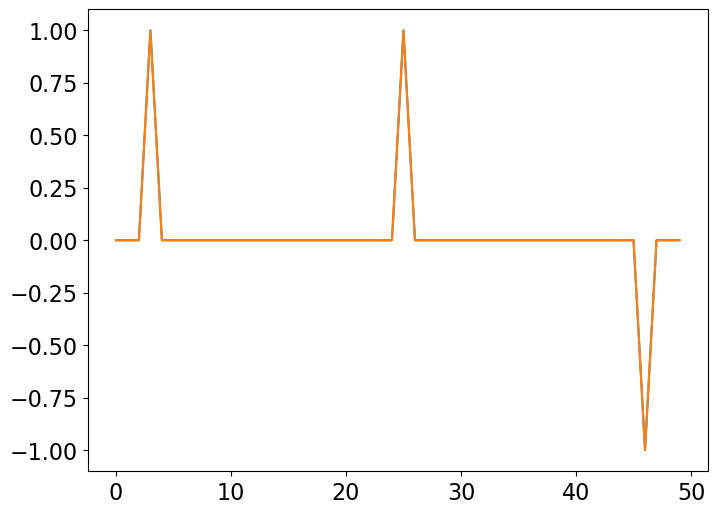

In [73]:
plt.plot(x.real)
plt.plot(xinv.real)

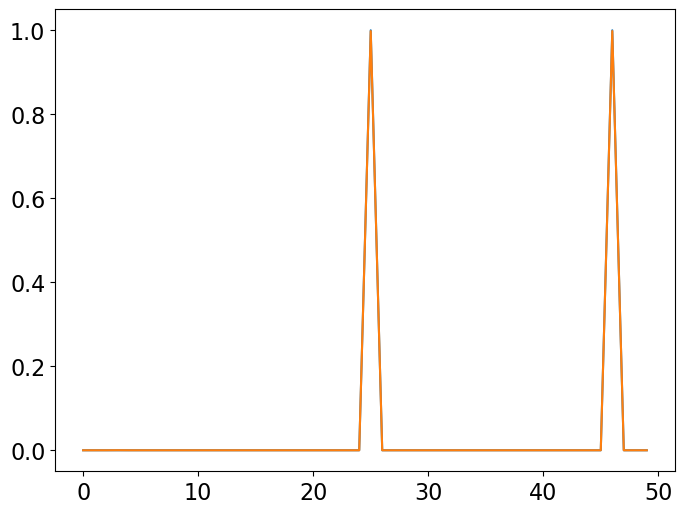

In [74]:
plt.plot(x.imag)
plt.plot(xinv.imag)

# SPGL1

In [75]:
np.random.seed(1)
ny, nx = 100, 50

x = np.zeros(nx)
x[nx // 2] = 1
x[3] = 1
x[nx - 4] = -1

A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = Aop * x

eps = 0.5
perc = 30
maxit = 2000

In [76]:
spgl1solve = SPGL1(Aop)

xhist = []

x = spgl1solve.setup(y=y, tau=1e-1, show=True)
x = spgl1solve.run(x, show=True, iter_lim=200, **dict(verbosity=2))[0]
spgl1solve.finalize(show=True)
xinv = x.copy()

SPGL1
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
SOp=None
tau=0.1     sigma=0
--------------------------------------------------------------------------------

SPGL1
No. rows              :      100     
No. columns           :       50

Initial tau           : 1.00e-01     
Two-norm of b         : 1.93e+01

Optimality tol        : 1.00e-04     
Target one-norm of x  : 1.00e-01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      200

iterr      Objective   Relative Gap      gnorm   stepg   nnz_x   nnz_g

    0  1.9252278e+01  8.3951530e-02   1.56e+02     0.0       0       0       
    1  1.8460688e+01  7.6308961e-14   1.43e+02     0.0       1       1       

EXIT -- Optimal solution found

Products with A     :       2        Total time   (secs) :     0.0
Products with A^H   :       2        Project time (secs) :     0.0
Newton iterations   :       0        Mat-vec time (secs) :     0.0
Line 

In [77]:
x-xinv

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
xinv1, _, _ = spgl1(Aop, y, tau=1e-1, iter_lim=200, show=True, verbosity=0)

SPGL1
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
SOp=None
tau=0.1     sigma=0.0
--------------------------------------------------------------------------------


In [79]:
xinv2, _, _ = spgl1_old(Aop, y, tau=1e-1, iter_lim=200, verbosity=1)


SPGL1
No. rows              :      100     
No. columns           :       50

Initial tau           : 1.00e-01     
Two-norm of b         : 1.93e+01

Optimality tol        : 1.00e-04     
Target one-norm of x  : 1.00e-01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      200


EXIT -- Optimal solution found

Products with A     :       2        Total time   (secs) :     0.0
Products with A^H   :       2        Project time (secs) :     0.0
Newton iterations   :       0        Mat-vec time (secs) :     0.0
Line search its     :       0        Subspace iterations :       0


In [80]:
xinv-xinv2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# IRLS

## Data

In [81]:
#np.random.seed(10)

N = 30
x = np.array([1.0, 2.0])
sigma = 1

t = np.arange(N, dtype="float64")
LRop = pylops.LinearRegression(t, dtype="float64")
y = LRop * x
yn = y + np.random.normal(0, sigma, N)

# Add outliers
yn[1] += 40
yn[N - 2] -= 20

# IRLS
nouter = 15
epsR = 1e-2
epsI = 0
tolIRLS = 1e-2
x0 = np.array([0.1, 0.2])

In [82]:
xirls, nouter = irls(
    LRop,
    yn,
    x0=x0,
    nouter=nouter,
    threshR=False,
    epsR=epsR,
    epsI=epsI,
    tolIRLS=tolIRLS,
    show=True,
    **dict(iter_lim=10)
)
print(f"IRLS converged at {nouter} iterations...")
xirls

IRLS (data)
--------------------------------------------------------------------------------
The Operator Op has 30 rows and 2 cols
threshR = False	epsR = 0.01	epsI = 0
tolIRL = None
--------------------------------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.8405e+00          4.251e+01
     2         2.0947e+00          4.477e+01
     3         1.8117e+00          4.503e+01
     4         1.6688e+00          4.519e+01
     5         1.6101e+00          4.525e+01
     6         1.5458e+00          4.532e+01
     7         1.4767e+00          4.540e+01
     8         1.4105e+00          4.547e+01
     9         1.3556e+00          4.553e+01
    10         1.3200e+00          4.557e+01
    11         1.3076e+00          4.559e+01
    12         1.3043e+00          4.560e+01

Iterations = 12        Total time (s) = 0.00
--------------------------------------------------------------------------------

IRLS converged at 12 iter

array([1.40434376, 1.97752806])

In [83]:
xirls1, nouter, xirls_hist, rw_hist = irls_old(
    LRop,
    yn,
    x0=x0,
    nouter=nouter-1,
    threshR=False,
    epsR=epsR,
    epsI=epsI,
    tolIRLS=tolIRLS,
    returnhistory=True,
    **dict(maxiter=10)
)
xirls1, nouter

(array([1.40434376, 1.97752806]), 10)

In [84]:
xirls-xirls1

array([-1.03161923e-12,  2.54907206e-13])

## Model

In [85]:
#np.random.seed(5)

N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
Aop = pylops.MatrixMult(A)

x = np.random.rand(M)
x[np.abs(x) < 0.9] = 0
y = Aop * x

# IRLS
nouter=10
x0 = np.random.normal(0,1, M)

In [86]:
xirls = pylops.optimization.sparsity.irls(
    Aop, y, x0=x0, nouter=nouter, epsI=1e-5, kind="model", **dict(iter_lim=10)
)[0]

In [87]:
xirls1 = irls_old(
    Aop, y, x0=x0, nouter=nouter-1, epsI=1e-5, kind="model", **dict(iter_lim=10)
)[0]

In [88]:
xirls - xirls1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

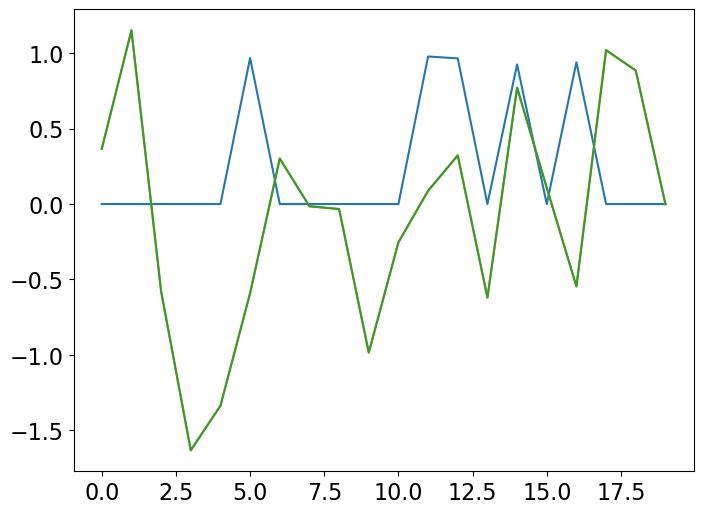

In [89]:
plt.plot(x)
plt.plot(xirls)
plt.plot(xirls1);

# OMP

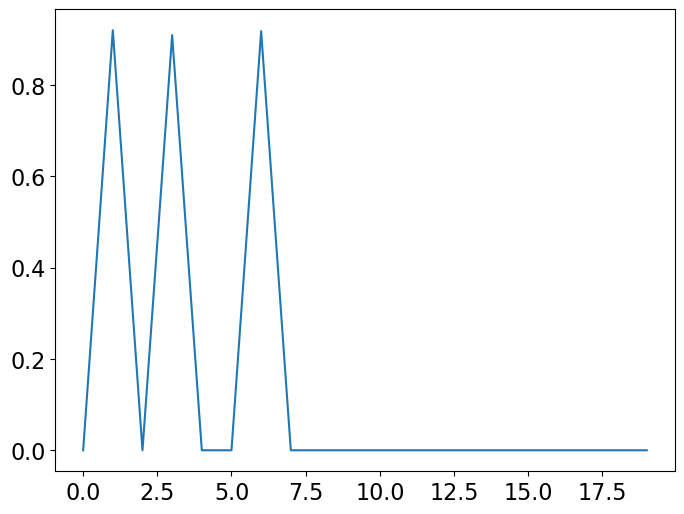

In [90]:
np.random.seed(12)

N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
Aop = pylops.MatrixMult(A)

x = np.random.rand(M)
x[x < 0.9] = 0
y = Aop * x

plt.plot(x);

In [91]:
ompsolve = OMP(Aop)

xhist = []
ompsolve.callback = lambda x, cols: callback1(x, cols, xhist)

ompsolve.setup(y=y, niter_outer=maxit, niter_inner=0, sigma=1e-4, show=True)
x, cols = ompsolve.run([], [], show=True)
xmp = ompsolve.finalize(x, cols, show=True)

OMP(Only MP)
-------------------------------------------------------
The Operator Op has 15 rows and 20 cols
sigma = 1.00e-04	niter_outer = 2000
niter_inner = 0	normalization=False
-------------------------------------------------------
    Itn           x[0]              r2norm
     1         1.4838e+00          1.062e+00
     2         1.4838e+00          7.168e-01
     3         1.4838e+00          4.542e-01
     4         1.1356e+00          2.916e-01
     5         1.1356e+00          2.041e-01
     6         1.0110e+00          1.616e-01
     7         1.0110e+00          1.158e-01
     8         1.0110e+00          7.313e-02
     9         9.5492e-01          4.697e-02
    10         9.5492e-01          3.289e-02
    11         9.3487e-01          2.607e-02
    21         9.2063e-01          6.765e-04

Iterations = 27        Total time (s) = 0.00
-------------------------------------------------------



In [92]:
eps = 1e-2
maxit = 500

xmp1, nouter, cost = omp(
    Aop,
    y,
    niter_outer=maxit, niter_inner=0, sigma=1e-4, show=True
)
print(f"MP converged at {nouter} iterations...")

OMP(Only MP)
-------------------------------------------------------
The Operator Op has 15 rows and 20 cols
sigma = 1.00e-04	niter_outer = 500
niter_inner = 0	normalization=False
-------------------------------------------------------
    Itn           x[0]              r2norm
     1         1.4838e+00          1.062e+00
     2         1.4838e+00          7.168e-01
     3         1.4838e+00          4.542e-01
     4         1.1356e+00          2.916e-01
     5         1.1356e+00          2.041e-01
     6         1.0110e+00          1.616e-01
     7         1.0110e+00          1.158e-01
     8         1.0110e+00          7.313e-02
     9         9.5492e-01          4.697e-02
    10         9.5492e-01          3.289e-02
    11         9.3487e-01          2.607e-02
    21         9.2063e-01          6.765e-04

Iterations = 27        Total time (s) = 0.00
-------------------------------------------------------

MP converged at 27 iterations...


In [93]:
xmp_old, nouter, cost = omp_old(
    Aop,
    y,
    niter_outer=maxit, niter_inner=0, sigma=1e-4, show=True
)
print(f"MP converged at {nouter} iterations...")

MP optimization
-----------------------------------------------------------------
The Operator Op has 15 rows and 20 cols
sigma = 1.00e-04	niter_outer = 500	niter_inner = 0
normalization=False
-----------------------------------------------------------------
    Itn           r2norm
     2         1.06212e+00
     3         7.16765e-01
     4         4.54210e-01
     5         2.91609e-01
     6         2.04078e-01
     7         1.61630e-01
     8         1.15757e-01
     9         7.31338e-02
    10         4.69702e-02
    11         3.28927e-02
    21         8.53498e-04

Iterations = 27        Total time (s) = 0.00
-----------------------------------------------------------------

MP converged at 27 iterations...


In [94]:
xmp-xmp1, xmp-xmp_old

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [95]:
xomp, nouter, cost = omp(
    Aop,
    y,
    niter_outer=maxit, sigma=1e-4, show=True
)
print(f"OMP converged at {nouter} iterations...")

OMP
-------------------------------------------------------
The Operator Op has 15 rows and 20 cols
sigma = 1.00e-04	niter_outer = 500
niter_inner = 40	normalization=False
-------------------------------------------------------
    Itn           x[0]              r2norm
     1         1.4838e+00          1.062e+00
     2         1.4672e+00          7.166e-01
     3         9.2025e-01          2.530e-16

Iterations = 3        Total time (s) = 0.00
-------------------------------------------------------

OMP converged at 3 iterations...


In [96]:
xomp_old, nouter, cost = omp_old(
    Aop,
    y,
    niter_outer=maxit, sigma=1e-4, show=True
)
print(f"OMP converged at {nouter} iterations...")

OMP optimization
-----------------------------------------------------------------
The Operator Op has 15 rows and 20 cols
sigma = 1.00e-04	niter_outer = 500	niter_inner = 40
normalization=False
-----------------------------------------------------------------
    Itn           r2norm
     2         1.06212e+00
     3         7.16574e-01
     4         2.52961e-16

Iterations = 3        Total time (s) = 0.00
-----------------------------------------------------------------

OMP converged at 3 iterations...


In [97]:
xomp-xomp_old

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Split-Bregman

In [98]:
np.random.seed(1)

nx = 101
x = np.zeros(nx)
x[: nx // 2] = 10
x[nx // 2 : 3 * nx // 4] = -5

Iop = pylops.Identity(nx)

n = np.random.normal(0, 1, nx)
y = Iop * (x + n)

#SB
Dop = pylops.FirstDerivative(nx, edge=True, kind="backward")
mu = 0.01
lamda = 0.3
niter_out = 50
niter_in = 3

In [99]:
xinv, niter, cost = splitbregman(
    Iop,
    y,
    [Dop],
    niter_outer=1,
    niter_inner=1,
    mu=mu,
    epsRL1s=[lamda],
    tol=1e-4,
    tau=1.0,
    show=True,
    show_inner=True,
    **dict(iter_lim=30, damp=1e-10)
)

SplitBregman
-----------------------------------------------------------------
The Operator Op has 101 rows and 101 cols
niter_outer =   1     niter_inner =   1   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.3]	  epsL2 = []
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 101 rows and 101 cols
Regs=[<101x101 FirstDerivative with dtype=float64>]
epsRs=[5.477225575051661]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 202 rows and 101 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.497e+01  7.497e+01    1.0e+00

In [100]:
sbsolve = SplitBregman(Iop)

xhist = []
sbsolve.callback = lambda x: callback(x, xhist)

xinv = sbsolve.setup(y, [Dop], niter_outer=niter_out, niter_inner=niter_in,
                     mu=mu, epsRL1s=[lamda], tol=1e-4, tau=1.0, show=True)
xinv = sbsolve.run(xinv, show=True, **dict(iter_lim=30, damp=1e-10))
sbsolve.finalize(show=True)

SplitBregman
-----------------------------------------------------------------
The Operator Op has 101 rows and 101 cols
niter_outer =  50     niter_inner =   3   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.3]	  epsL2 = []
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     9.9825e+00       1.347e+00        2.050e+01
     2     9.9024e+00       1.049e+00        1.908e+01
     3     9.8909e+00       8.592e-01        1.958e+01
     4     9.8846e+00       7.707e-01        1.906e+01
     5     9.8780e+00       7.154e-01        1.930e+01
     6     9.8709e+00       6.846e-01        1.893e+01
     7     9.8639e+00       6.639e-01        1.855e+01
     8     9.8572e+00       6.452e-01        1.843e+01
     9     9.8511e+00       6.263e-01        1.838e+01
    10     9.8457e+00       6.092e-01        1.833e+01
    11     9.8408e+00       5.941e-01        1.835e+01
    21     9.8109e+00       5.145e-01        1.8

In [101]:
xinv1, niter, cost = splitbregman(
    Iop,
    y,
    [Dop],
    niter_outer=niter_out,
    niter_inner=niter_in,
    mu=mu,
    epsRL1s=[lamda],
    tol=1e-4,
    tau=1.0,
    show=True,
    show_inner=False,
    **dict(iter_lim=30, damp=1e-10)
)

SplitBregman
-----------------------------------------------------------------
The Operator Op has 101 rows and 101 cols
niter_outer =  50     niter_inner =   3   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.3]	  epsL2 = []
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     9.9825e+00       1.347e+00        2.050e+01
     2     9.9024e+00       1.049e+00        1.908e+01
     3     9.8909e+00       8.592e-01        1.958e+01
     4     9.8846e+00       7.707e-01        1.906e+01
     5     9.8780e+00       7.154e-01        1.930e+01
     6     9.8709e+00       6.846e-01        1.893e+01
     7     9.8639e+00       6.639e-01        1.855e+01
     8     9.8572e+00       6.452e-01        1.843e+01
     9     9.8511e+00       6.263e-01        1.838e+01
    10     9.8457e+00       6.092e-01        1.833e+01
    11     9.8408e+00       5.941e-01        1.835e+01
    21     9.8109e+00       5.145e-01        1.8

In [102]:
xinv2, niter = splitbregman_old(
    Iop,
    [Dop],
    y,
    niter_outer=niter_out,
    niter_inner=niter_in,
    mu=mu,
    epsRL1s=[lamda],
    tol=1e-4,
    tau=1.0,
    **dict(iter_lim=30, damp=1e-10, show=True)
)

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 101 rows and 101 cols
niter_outer =  50     niter_inner =   3   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.3]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   9.98248e+00        1.347e+00        2.050e+01
     2   9.90243e+00        1.049e+00        1.908e+01
     3   9.89086e+00        8.592e-01        1.958e+01
     4   9.88456e+00        7.707e-01        1.906e+01
     5   9.87800e+00        7.154e-01        1.930e+01
     6   9.87094e+00        6.846e-01        1.893e+01
     7   9.86385e+00        6.639e-01        1.855e+01
     8   9.85717e+00        6.452e-01        1.843e+01
     9   9.85111e+00        6.263e-01        1.838e+01
    10   9.84569e+00        6.092e-01        1.833e+01
    11   9.84085e+00        5.941e-01        1.835e+01
    12   9.83647e+00        5.780e-01    

In [103]:
xinv-xinv1, xinv-xinv2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 1.77635684e-15,  0.00000000e+00, -1.77635684e-15,  1.77635684e-15,
         1.77635684e-15,  1.77635684e-15,  1.77635684e-15,  1.77635684e-15,
         1.77635684e-15, -1.77635684e-15,  0.00000000e+00,  1.77635684e-15,
         1.77635684e-15,  0.00000000e+00, -3.55271368e-15, -1.77635684e-15,
        -1.77635684e-15, -1.77635684e-15,  3.55271368e-15,  1.77635684e-15,
         1.77635684e-15,  1.77635684e-15, -3.55271368e-15, -3.55271368e-15,
        -1.77635684e-15, -1.77635684e-15,  1.77635684e-15, -1.77635684e-15,
         3.552

## Split-Bregman with complex numbers

SplitBregman
-----------------------------------------------------------------
The Operator Op has 101 rows and 101 cols
niter_outer =  50     niter_inner =   3   tol = 1.00e-04
mu = 1.00e-02         epsL1 = [0.3]	  epsL2 = []
-----------------------------------------------------------------
    Itn          x[0]            r2norm           r12norm
     1    9.98e+00-8.98e-20j    1.347e+00        2.050e+01
     2    9.90e+00-5.62e-19j    1.049e+00        1.908e+01
     3    9.89e+00-1.88e-18j    8.592e-01        1.958e+01
     4    9.88e+00-4.52e-18j    7.707e-01        1.906e+01
     5    9.88e+00-8.66e-18j    7.154e-01        1.930e+01
     6    9.87e+00-1.44e-17j    6.846e-01        1.893e+01
     7    9.86e+00-2.18e-17j    6.639e-01        1.855e+01
     8    9.86e+00-3.03e-17j    6.452e-01        1.843e+01
     9    9.85e+00-3.97e-17j    6.263e-01        1.838e+01
    10    9.85e+00-4.97e-17j    6.092e-01        1.833e+01
    11    9.84e+00-5.97e-17j    5.941e-01        1.835e+01


/opt/miniconda3/envs/pylops/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/pylops/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


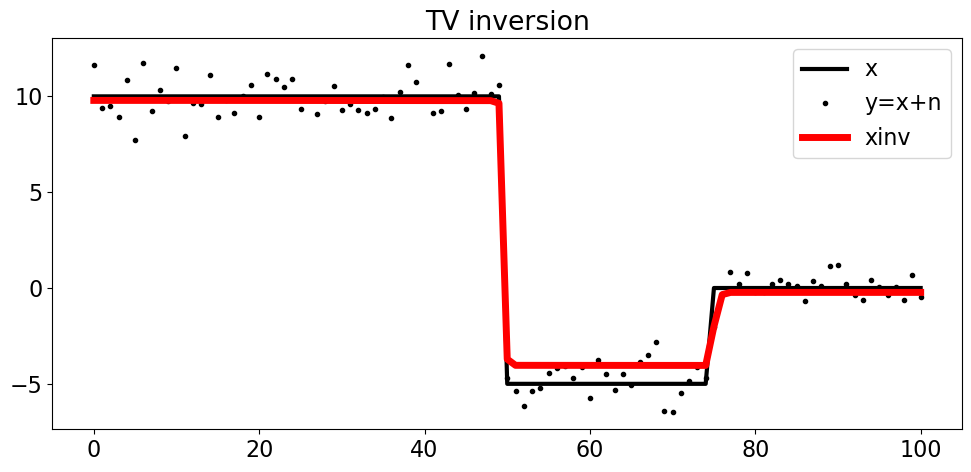

In [104]:
Iop.dtype = np.complex128
Dop.dtype = np.complex128
x0 = np.zeros(nx).astype(np.complex128)
y = y.astype(np.complex128)

xinv, niter, cost = splitbregman(
    Iop,
    y,
    [Dop],
    x0=x0,
    niter_outer=niter_out,
    niter_inner=niter_in,
    mu=mu,
    epsRL1s=[lamda],
    tol=1e-4,
    tau=1.0,
    show=True,
    show_inner=False,
    **dict(iter_lim=30, damp=1e-10)
)

plt.figure(figsize=(10, 5))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv, "r", lw=5, label="xinv")
plt.legend()
plt.title("TV inversion")
plt.tight_layout()

# Callback classes

In [105]:
from pylops.optimization.callback import Callbacks, MetricsCallback

class LoggingCallback(Callbacks):
    def on_setup_begin(self, solver, x):
        print(f"Setting up")
    def on_setup_end(self, solver, x):
        print(f"i at end of setup: {solver.iiter}")    
    def on_step_begin(self, solver, x):
        print(f"i at start of step: {solver.iiter}")
    def on_step_end(self, solver, x):
        print(f"i at end of step: {solver.iiter}")

class StoreIterCallback(Callbacks):
    def __init__(self):
        self.stored = []
    def on_step_end(self, solver, x):
        self.stored.append(solver.iiter)

In [106]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [107]:
cb_log = LoggingCallback()
cb_sto = StoreIterCallback()

cgsolve = CGLS(Aop, callbacks=[cb_log, cb_sto])
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=False)[0]

Setting up
i at end of setup: 0
i at start of step: 0
i at end of step: 1
i at start of step: 1
i at end of step: 2
i at start of step: 2
i at end of step: 3
i at start of step: 3
i at end of step: 4
i at start of step: 4
i at end of step: 5
i at start of step: 5
i at end of step: 6
i at start of step: 6
i at end of step: 7
i at start of step: 7
i at end of step: 8
i at start of step: 8
i at end of step: 9
i at start of step: 9
i at end of step: 10
i at start of step: 10
i at end of step: 11
i at start of step: 11
i at end of step: 12
i at start of step: 12
i at end of step: 13
i at start of step: 13
i at end of step: 14
i at start of step: 14
i at end of step: 15
i at start of step: 15
i at end of step: 16
i at start of step: 16
i at end of step: 17
i at start of step: 17
i at end of step: 18
i at start of step: 18
i at end of step: 19
i at start of step: 19
i at end of step: 20
i at start of step: 20
i at end of step: 21
i at start of step: 21
i at end of step: 22
i at start of step:

Finally let's use the metrics callback, who allows keeping tracks of various metrics

In [108]:
np.random.seed(1)
ny, nx = 100, 50
x = np.random.normal(0, 1, nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

mt_log = MetricsCallback(x)

cgsolve = CGLS(Aop, callbacks=[mt_log, ])
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=False)[0]

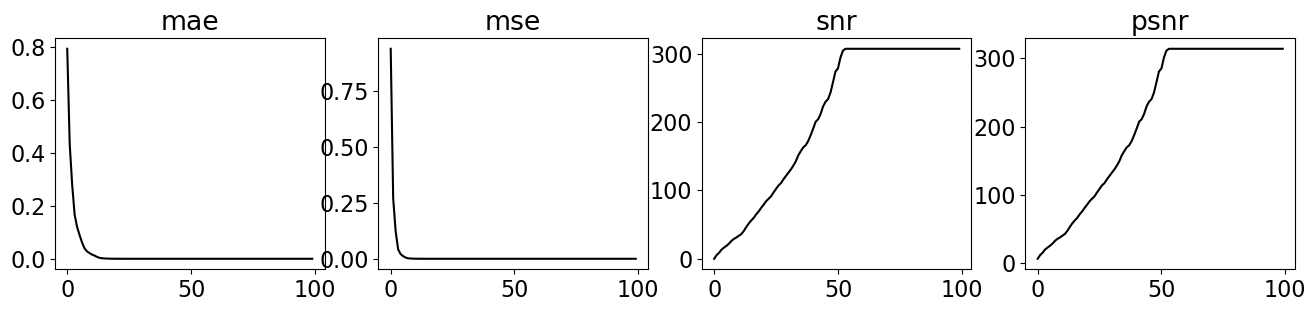

In [109]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3))
for i, metric in enumerate(['mae', 'mse', 'snr', 'psnr']):
    axs[i].plot(mt_log.metrics[metric], 'k')
    axs[i].set_title(metric)

# Callback classes as stopping ci

In [110]:
class StopCallback(Callbacks):
    def __init__(self, sigma):
        self.sigma = sigma
        self.stop = False
    def on_step_end(self, solver, x):
        if solver.cost1[-1] < self.sigma * solver.cost1[0]:
            print('Reached accuracy at it=', len(solver.cost1))
            self.stop = True

In [111]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [112]:
cb_sto = StoreIterCallback()
cb_stop = StopCallback(0.001)

cgsolve = CGLS(Aop, callbacks=[cb_stop, cb_sto])
xest = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
cgsolve.niter = 20
for i in range(20):
    xest = cgsolve.step(x, True if i % 10 == 0 else False)
    if np.any([False if not hasattr(callback, "stop") else callback.stop for callback in cgsolve.callbacks]):
        break
cgsolve.finalize(True)

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        1.0062e+00         3.1506e+01     3.1506e+01
    11        9.9248e-01         3.8881e-01     3.8881e-01
Reached accuracy at it= 16

Iterations = 15        Total time (s) = 0.00
-----------------------------------------------------------------



In [113]:
cb_sto = StoreIterCallback()
cb_stop = StopCallback(0.001)

cgsolve = CGLS(Aop, callbacks=[cb_stop, cb_sto])
xest = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, niter=30, show=True)[0]

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 30
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
     5        1.0986e+00         3.7566e+00     3.7566e+00
     6        1.0980e+00         2.3773e+00     2.3773e+00
     7        1.0594e+00         1.5883e+00     1.5883e+00
     8        1.0419e+00         1.1075e+00     1.1075e+00
     9        1.0396e+00         7.8965e-01     7.8965e-01
    10        1.0275e+00         5.7929e-01     5.7929e-01
    11        1.0200e+00         3.8881e-01     3.8881e-01
Reached accuracy at it= 16

Iterations = 15        Total time (s)

In [114]:
xest1 = cgls(Aop, y, x0=np.zeros(nx), tol=0, rtol=0.001, niter=30, show=True)[0]


CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 30
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
     5        1.0986e+00         3.7566e+00     3.7566e+00
     6        1.0980e+00         2.3773e+00     2.3773e+00
     7        1.0594e+00         1.5883e+00     1.5883e+00
     8        1.0419e+00         1.1075e+00     1.1075e+00
     9        1.0396e+00         7.8965e-01     7.8965e-01
    10        1.0275e+00         5.7929e-01     5.7929e-01
    11        1.0200e+00         3.8881e-01     3.8881e-01

Iterations = 15        Total time (s) = 0.00
-------------------

In [115]:
xest - xest1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [116]:
np.random.seed(1)
ny, nx = 100, 50
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)

x = np.zeros(nx)
x[nx // 2] = 1
x[3] = 1
x[nx - 4] = -1

y = A @ x

In [117]:
xest1, iiter, cost = ista(Aop, y, x0=np.zeros(nx), tol=0, rtol=0.1, niter=30, show=True)
iiter, cost, cost[-2] / cost[0], cost[-1] / cost[0]


ISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 1.000000e-01	tol = 0.000000e+00	niter = 30
alpha = 3.546044e-03	thresh = 1.773022e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7913e-02         1.853e+02   1.857e+02   9.058e-01
     2      -6.9782e-02         3.696e+01   3.743e+01   3.125e-01
     3      -6.7427e-02         1.612e+01   1.661e+01   1.701e-01

Iterations = 3        Total time (s) = 0.00
--------------------------------------------------------------------------------



(3,
 array([185.72256135,  37.43074357,  16.60786039]),
 np.float64(0.2015411768046788),
 np.float64(0.08942295578016335))

In [118]:
xest1, iiter, cost = fista(Aop, y, x0=np.zeros(nx), tol=0, rtol=0.1, niter=30, show=True)
iiter, cost, cost[-2] / cost[0], cost[-1] / cost[0]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
eps = 1.000000e-01	tol = 0.000000e+00	niter = 30
alpha = 3.546044e-03	thresh = 1.773022e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.7913e-02         3.696e+01   3.736e+01   9.058e-01
     2      -6.9782e-02         1.612e+01   1.659e+01   3.125e-01
     3      -6.6764e-02         8.085e+00   8.574e+00   2.180e-01
     4      -5.6164e-02         4.592e+00   5.074e+00   1.603e-01
     5      -4.2921e-02         2.804e+00   3.263e+00   1.258e-01

Iterations = 5        Total time (s) = 0.00
--------------------------------------------------------------------------------



(5,
 array([37.357493  , 16.59447281,  8.57439215,  5.07408979,  3.26301969]),
 np.float64(0.13582522221417026),
 np.float64(0.08734578861980863))

In [119]:
xest1, iiter, cost = omp(Aop, y, sigma=0, rtol=0.1, niter_outer=30, show=True)
iiter, cost, cost[-2] / cost[0], cost[-1] / cost[0]


OMP
-------------------------------------------------------
The Operator Op has 100 rows and 50 cols
sigma = 0.00e+00	niter_outer = 30
niter_inner = 40	normalization=False
-------------------------------------------------------
    Itn           x[0]              r2norm
     1         1.2314e+00          1.338e+01
     2         1.1548e+00          9.298e+00
     3         1.0000e+00          7.706e-15

Iterations = 3        Total time (s) = 0.00
-------------------------------------------------------



(3,
 array([1.92522782e+01, 1.33812859e+01, 9.29833831e+00, 7.70610952e-15]),
 np.float64(0.48297340374529485),
 np.float64(4.0027000717463895e-16))

In [120]:
rcallback = ResidualNormCallback(1e-1)
irlssolve = IRLS(Aop, callbacks=[rcallback, ])

irlssolve.setup(y=y, epsI=0.1, tolIRLS=0, kind="model", show=True)
xirls = irlssolve.run(np.zeros(Aop.shape[1], dtype=Aop.dtype), nouter=100, iter_lim=2, show=True)
irlssolve.finalize(show=True)

IRLS (model)
--------------------------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
threshR = False	epsR = 1e-10	epsI = 0.1
tolIRL = None
--------------------------------------------------------------------------------
    Itn           x[0]              r2norm
     1        -1.1171e-01          7.304e+00
     2        -1.9710e-02          3.071e+00
     3        -2.8854e-03          1.927e+00
     4        -4.0296e-04          2.015e+00
     5        -5.6577e-05          1.911e+00

Iterations = 5        Total time (s) = 0.00
--------------------------------------------------------------------------------



In [121]:
irlssolve.cost, irlssolve.cost[-1] / irlssolve.cost[0]

([19.25227816221631,
  7.304401996632209,
  3.0711133126126477,
  1.9274029549009553,
  2.014666844038568,
  1.9107061204362645],
 0.09924571545959344)

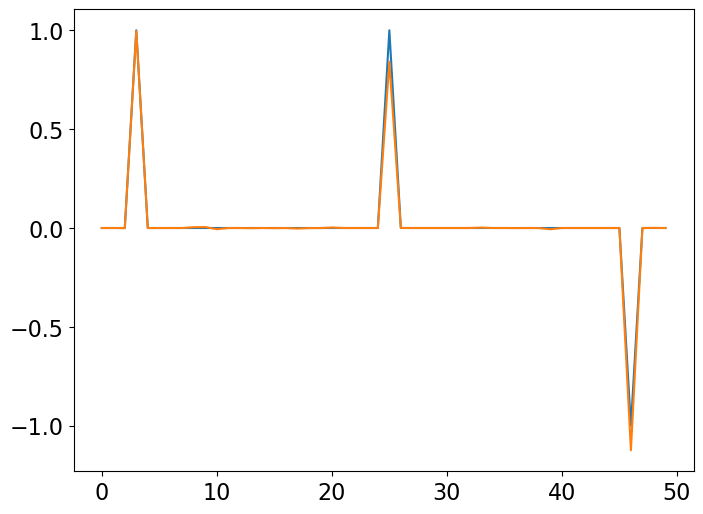

In [122]:
plt.plot(x)
plt.plot(xirls)

In [123]:
xest1, iiter, cost = splitbregman(Aop, y, RegsL1=[Identity(x.shape),], epsRL1s=[.1, ],
                                  rtol=0.9, niter_outer=8, niter_inner=5, show=True)
iiter, cost, cost[-2] / cost[0], cost[-1] / cost[0]


SplitBregman
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
niter_outer =   8     niter_inner =   5   tol = 1.00e-10
mu = 1.00e+00         epsL1 = [0.1]	  epsL2 = []
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1    -6.2784e-06       2.676e-06        3.001e+00
     2    -6.5184e-06       2.666e-06        3.001e+00
     3    -6.7600e-06       2.656e-06        3.001e+00
     4    -6.9959e-06       2.646e-06        3.001e+00
     5    -7.2292e-06       2.636e-06        3.001e+00
     6    -7.4599e-06       2.627e-06        3.001e+00
     7    -7.6879e-06       2.617e-06        3.001e+00
     8    -7.9134e-06       2.608e-06        3.001e+00

Iterations = 8        Total time (s) = 0.01
-----------------------------------------------------------------



(8,
 array([3.00117749, 3.00116953, 3.0011616 , 3.00115375, 3.00114596,
        3.00113822, 3.00113053, 3.0011229 ]),
 np.float64(0.99998435281906),
 np.float64(0.9999818103869937))